In [54]:
# Standard imports
import cv2
import numpy as np;
import pandas as pd
import matplotlib.pyplot as plt
cv2.useOptimized()
#%pylab inline
#pylab.rcParams['figure.figsize'] = (10, 8)
from sklearn import preprocessing

from searchwing import roiDescriptor

descriptorsPathIn="/home/julle/ControlerProjekte/SearchWing/Data/images/Moonbird/test/extracedDescriptors.h5"
classifierPathOut="/home/julle/ControlerProjekte/SearchWing/Data/images/Moonbird/test/classifier.pkl"

Populating the interactive namespace from numpy and matplotlib


In [73]:
print("\nRead dataset with descriptors from "+descriptorsPathIn)
df_raw = pd.read_hdf(descriptorsPathIn,
                key="table")
df_raw=df_raw.dropna(axis=0)
df_raw.shape
print("Dataset shape:"+str(df_raw.shape)+" (Entrys,Features)")

Read dataset with descriptors from /home/julle/ControlerProjekte/SearchWing/Data/images/Moonbird/test/extracedDescriptors.h5
Dataset shape:(62, 184) (Entrys,Features)


In [76]:
print("Dataset got the following classdistribution")
print(pd.value_counts(df_raw["class"]))

Dataset got the following classdistribution
nature    45
boat      17
Name: class, dtype: int64


In [77]:
#Weight nature samples by pixcount to get more samples with high pixcount for training
df_boat=df_raw[df_raw["class"]=="boat"]
sampleCountNature=int(df_boat.shape[0])

df_nature = df_raw[df_raw["class"]=="nature"]
weights = 5*df_nature["pixcount"]
weightsnp=np.array(weights.values,dtype=float)
weightsnp=weightsnp/sum(weightsnp) #norm
indizes=range(0,len(weightsnp))
sampleIndizes=np.random.choice(indizes,sampleCountNature,replace=False, p=weightsnp)
df_nature = df_nature.iloc[sampleIndizes,:] #df_nature.sample(n=654,weights="pixcount",axis=0)
#df_boat= df_raw[df_raw["class"]=="boat"]

df=pd.concat([df_nature,df_boat])
print("Sample same amount of boats...")
print("Dataset got the following classdistribution")
print(pd.value_counts(df["class"]))
Y=df['class']
X=df

Sample same amount of boats...
Dataset got the following classdistribution
nature    17
boat      17
Name: class, dtype: int64


In [65]:
from sklearn.model_selection import train_test_split
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=0.25)

X_train=X_train.iloc[:,9:]  #-11 skip hmoments
X_test_meta=X_test.iloc[:,0:8]
X_test=X_test.iloc[:,9:]#

#X_train.head()

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print("\nLearn RandomForest classifier...")

clf = RandomForestClassifier(n_estimators=25,criterion="entropy",n_jobs=4,class_weight="balanced")
clf = clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = pd.DataFrame(clf.predict(X_test) )

# Compute confusion matrix
print("Compute confusion matrix")
cnf_matrix_train = confusion_matrix(y_train, y_pred_train)
np.set_printoptions(precision=2)
print(cnf_matrix_train)
cnf_matrix_test = confusion_matrix(y_test, y_pred_test)
np.set_printoptions(precision=2)
print(cnf_matrix_test)
print("Accuracy:",accuracy_score(y_test,y_pred_test))


Learn RandomForest classifier...
Compute confusion matrix
[[14  0]
 [ 0 32]]
[[ 3  0]
 [ 1 12]]
('Accuracy:', 0.9375)


In [27]:
from sklearn.externals import joblib
print("Save classifier to " + classifierPathOut +" ...")
joblib.dump(clf, classifierPathOut) 

["/home/julle/ControlerProjekte/SearchWing/Data/images/Moonbird/test/classifier.pkl'"]

In [79]:
#Print feature importances of learned classifier
print("\nPrint feature importances of learned classifier")
imp=clf.feature_importances_

descr= roiDescriptor.Descriptors()
colList=list(X_train.columns.values)

colorChannels=descr.channelNames
colorChannelsImportances = np.zeros([len(colorChannels)])
featureTypes=["mean","std","entropy","Hist","LBP","Mask"]
featureTypesImportances = np.zeros([len(featureTypes)])

for colIdx,oneColName in enumerate(colList,0):
    for chanIdx,oneChanName in enumerate(colorChannels,0):
        if oneChanName in oneColName:
            colorChannelsImportances[chanIdx]+=imp[colIdx]
    for featTypeIdx,oneFeatTypeName in enumerate(featureTypes,0):
        if oneFeatTypeName in oneColName:
            featureTypesImportances[featTypeIdx]+=imp[colIdx]

print("FeatureImportances for each Channel:")
for chanIdx,oneChanName in enumerate(colorChannels,0):
    print(oneChanName,colorChannelsImportances[chanIdx])
#print("Sum",sum(colorChannelsImportances))
print("FeatureImportances for each Featuretype:")
for featTypeIdx,oneFeatTypeName in enumerate(featureTypes,0):
    print(oneFeatTypeName,featureTypesImportances[featTypeIdx])

print("Show feature importances for each feature:")
imp=clf.feature_importances_
for i in xrange(len(X_train.columns)):
    print(str(X_train.columns[i])+":"+str(imp[i]))
    


FeatureImportances for each Channel:
('gray', 0.18227250568015682)
('hue', 0.3272079451630224)
('saturation', 0.12674851072172688)
('value', 0.2535062557589144)
FeatureImportances for each Featuretype:
('mean', 0.03134211258975732)
('std', 0.26673376413484395)
('entropy', 0.12858022858069443)
('Hist', 0.46281976136674585)
('LBP', 0.1345611160760117)
('Mask', 0.11026478267617955)
graymean:0.0
graystd:0.0
grayentropy:0.0
grayHist0:0.0
grayHist1:0.0
grayHist2:0.0
grayHist3:0.0
grayHist4:0.0
grayHist5:0.0
grayHist6:0.0
grayHist7:0.0
grayHist8:0.0
grayHist9:0.006858585376569724
grayHist10:0.0
grayHist11:0.05377624213839927
grayHist12:0.0
grayHist13:0.07285429249121095
grayHist14:0.0
grayHist15:0.0
grayHiststddev:0.006922684011558524
grayHistskew:0.010568831154635718
grayLBP0:0.0
grayLBP1:0.0
grayLBP2:0.006938716415170037
grayLBP3:0.0
grayLBP4:0.0
grayLBP5:0.0
grayLBP6:0.0
grayLBP7:0.0
grayLBP8:0.02435315409261257
grayLBP9:0.0
grayLBP10:0.0
grayLBP11:0.0
grayLBP12:0.0
grayLBP13:0.0
grayLBP14

Wrong detections
/home/julle/ControlerProjekte/SearchWing/Data/images/Moonbird/test/_AM_8691.JPG


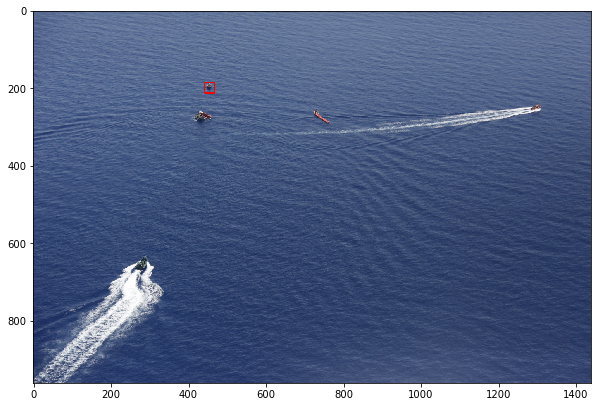

('true label:', 'boat')
/home/julle/ControlerProjekte/SearchWing/Data/images/Moonbird/test/_AM_8691.JPG


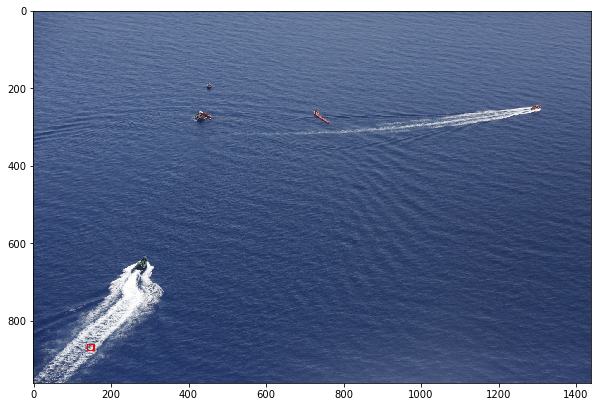

('true label:', 'nature')


In [58]:
#visualize wrong classifications
print("\nVisualize wrong classifications...")
y_test_meta=pd.concat([y_test,X_test_meta],axis=1)
#y_pred_test_meta=pd.concat([y_pred_test,X_test_meta],axis=1)

wrongClassified=[]
corrClassified=[]
for i in xrange(len(y_test_meta)):
    if(y_test_meta.iloc[i]['class']!=y_pred_test.iloc[i][0]):
        wrongClassified.append([y_test_meta.iloc[i]])
    elif(y_test_meta.iloc[i]['class']==y_pred_test.iloc[i][0]):
        if( (y_test_meta.iloc[i]['class']=='boat')):
            corrClassified.append([y_test_meta.iloc[i]])
        
print("Wrong detections")
for oneWrong in wrongClassified:
    xmin=oneWrong[0][5]
    ymin=oneWrong[0][6]
    xmax=oneWrong[0][7]
    ymax=oneWrong[0][8]
    path=oneWrong[0][1]
    print(path)
    img = cv2.imread(path, cv2.IMREAD_COLOR) # IMREAD_COLOR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255, 0, 0), 2)
    plt.imshow(img, cmap='gray')
    plt.show()
    print("true label:",oneWrong[0][0])
print("==============================================================================")